In [1]:
# need to check bias term
# need to check regularization term
# recurrent connection is all zero 


import sys
sys.path.append('../')

from low_rank_rnns.modules_connectivity_fullRank import *
from low_rank_rnns import TF, stats, plotting as plot, helpers, rankone, ranktwo, clustering

from matplotlib import pyplot as plt
# %matplotlib notebook
import random
import numpy as np

import torch

In [2]:
size = 400
noise_std = 1e-2
alpha = .1
lr = 1e-3

input_size = 3
output_size = 1


In [3]:
x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(10000)


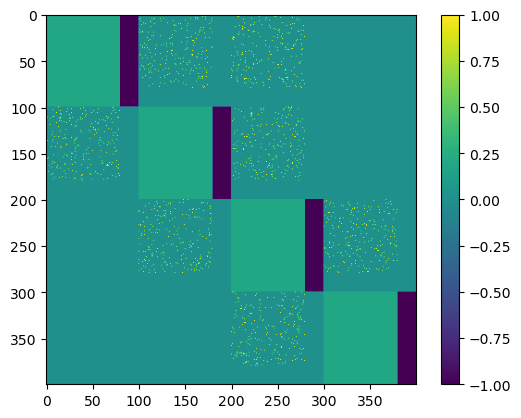

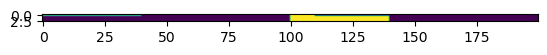

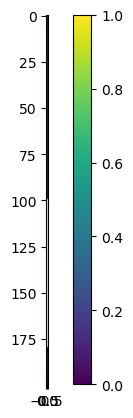

tensor(3.)


In [7]:

# local connections are continuous 
def create_local_conn(Inum, ratio, n_neurons):

    mask_rec = torch.zeros(n_neurons, n_neurons)
    
    mask_rec[:,n_neurons-Inum:] = -1
    
    mask_rec[:,:n_neurons-Inum] = ratio    

    return mask_rec



def create_area_conn(Inum, ratio, n_neurons): 
    mask_rec = torch.zeros(n_neurons, n_neurons)
    
    mask_rec[:,n_neurons-Inum:] = 0
    mask_rec[n_neurons-Inum:,:] = 0
    
    # Define the size of the matrix
    rows, cols = n_neurons-Inum, n_neurons-Inum
    
    # Create a zero matrix
    matrix = torch.zeros(rows, cols)
    
    # Calculate the number of entries to set to 1
    num_entries = int(ratio * rows * cols)
    
    # Randomly select indices
    indices = torch.randperm(rows * cols)[:num_entries]
    
    # Set the selected entries to 1
    matrix.view(-1)[indices] = 1
    
    mask_rec[:n_neurons-Inum,:n_neurons-Inum] = matrix

    return mask_rec


n_neurons = 400
n_inputs = 3
n_outputs = 1


mask_rec = torch.zeros(n_neurons, n_neurons)
mask_in = torch.zeros(n_inputs, n_neurons)
mask_out = torch.ones(n_neurons, n_outputs)


mask_rec[:100,0:100] = create_local_conn(20,0.2,100)
mask_rec[100:200,100:200] = create_local_conn(20,0.2,100)
mask_rec[200:300,200:300] = create_local_conn(20,0.2,100)
mask_rec[300:400,300:400] = create_local_conn(20,0.2,100)


connStrength = 0.0359


mask_rec[:100,100:200] = create_area_conn(20,connStrength,100)



mask_rec[100:200,0:100] = create_area_conn(20,connStrength,100)

mask_rec[100:200,200:300] = create_area_conn(20,connStrength,100)

mask_rec[200:300,100:200] = create_area_conn(20,connStrength,100)



mask_rec[200:300,300:400] = create_area_conn(20,connStrength,100)
mask_rec[300:400,200:300] = create_area_conn(20,connStrength,100)
mask_rec[0:100,200:300] = create_area_conn(20,connStrength,100)





mask_in[0,:40] = 1



mask_in[1:,100:140] = 1
mask_in[0,100:110] = 1


mask_out[:300,:] = 0
mask_out[380:,:] = 0



wi_mask = mask_in
wo_mask = mask_out
wrec_mask = mask_rec.t()

plt.imshow(mask_rec, cmap = 'viridis')
plt.colorbar()
plt.show()

plt.imshow(wi_mask[:,:200])
plt.show()
plt.imshow(wo_mask[200:])
plt.colorbar()
plt.show()


print(torch.sum(wrec_mask))

In [20]:

net = FullRankRNN(3, size, 1, noise_std, alpha, train_wi=True, train_wo = True, train_h0=True, 
                  wrec_mask = wrec_mask, wi_mask = wi_mask, wo_mask = wo_mask, 
                 b_init = None, add_biases = False)

# after trained, recurrent connectivity are all zero
# after trained, bias term will make test accuracy very low
net.non_linearity = torch.relu
net.out_non_linearity = torch.relu

# net.out_non_linearity = torch.eye

train(net, x_train, y_train, mask_train, n_epochs=50, lr=lr, batch_size=100, 
      mask_gradients = False, keep_best=True, cuda=True, early_stop=0.25, clip_gradient = 1)

x_val, y_val, mask_val = map_device([x_val, y_val, mask_val], net)


loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

Training...
initial loss: 1.000
epoch 0:  loss=1.000  (took 14.00 s)
epoch 1:  loss=0.967  (took 14.04 s) *
epoch 2:  loss=0.803  (took 13.95 s) *
epoch 3:  loss=0.726  (took 13.89 s) *
epoch 4:  loss=0.677  (took 13.92 s) *
epoch 5:  loss=0.508  (took 13.76 s) *
epoch 6:  loss=0.347  (took 13.66 s) *
epoch 7:  loss=0.303  (took 13.92 s) *
epoch 8:  loss=0.272  (took 14.07 s) *
epoch 9:  loss=0.255  (took 14.23 s) *
epoch 10:  loss=0.239  (took 13.93 s) *
loss=0.246, acc=0.999


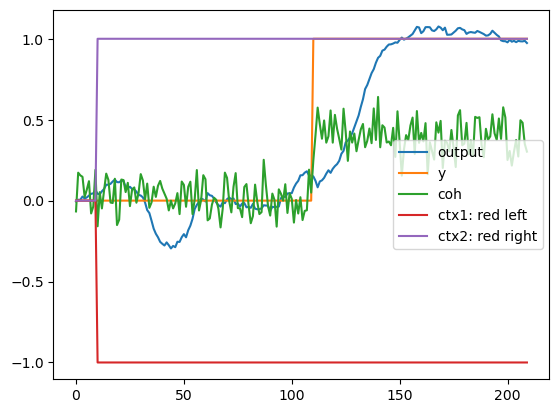

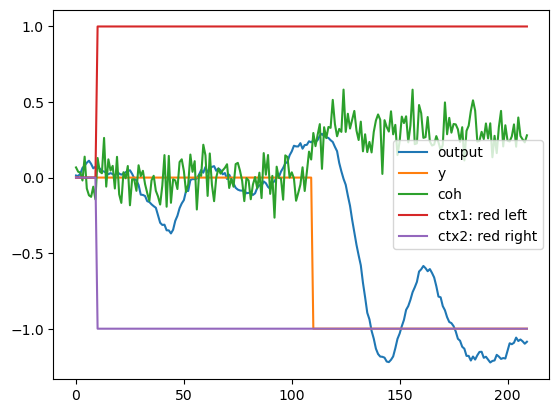

In [21]:
out = out.cpu()
y_val = y_val.cpu()
x_val = x_val.cpu()


# plot psth

In [22]:
traj = traj.cpu()
decisions = decisions.cpu()

traj1 = traj.detach().numpy()

traj1 = np.maximum(traj1,0)

decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

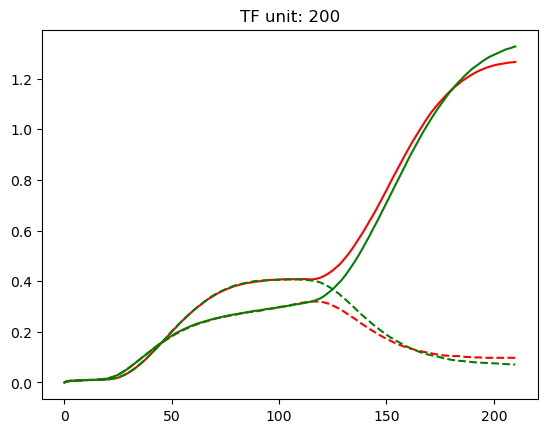

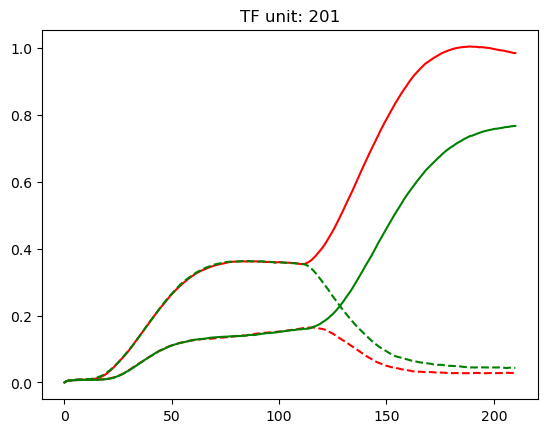

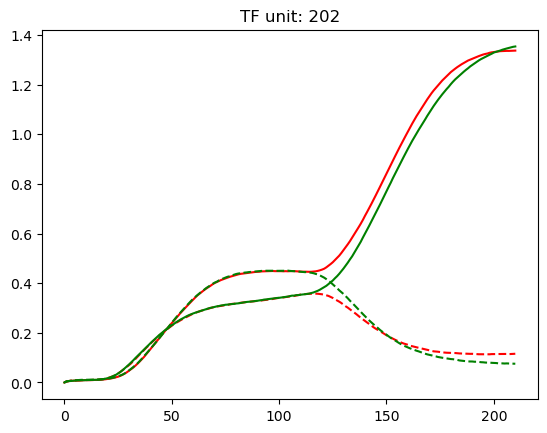

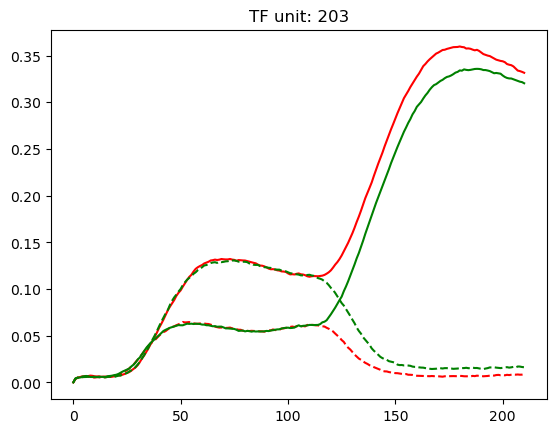

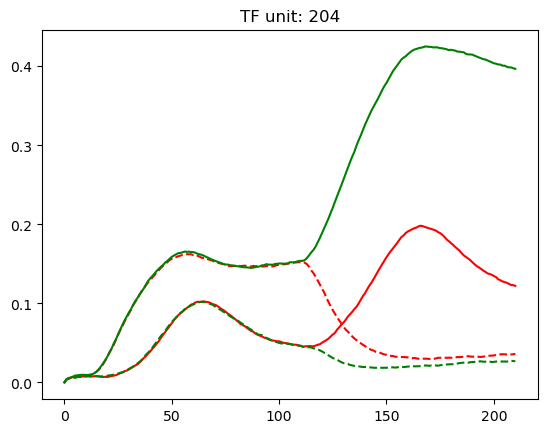

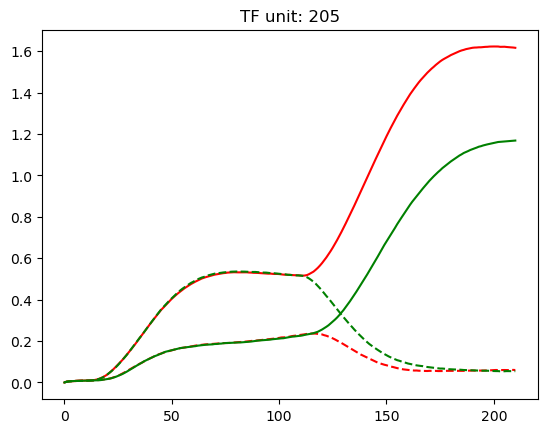

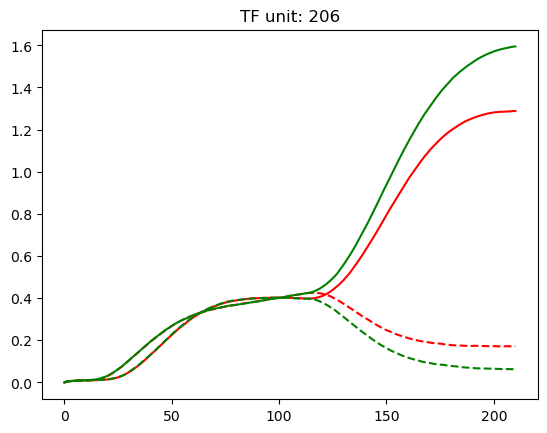

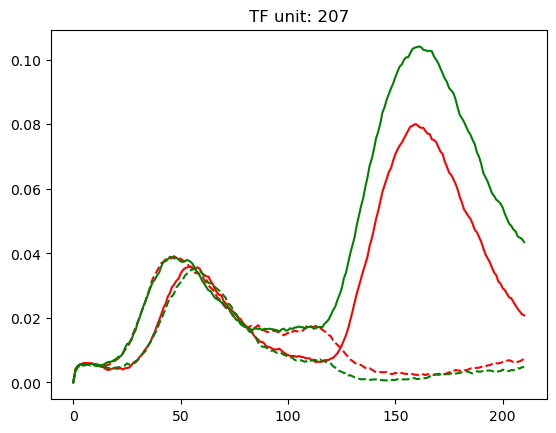

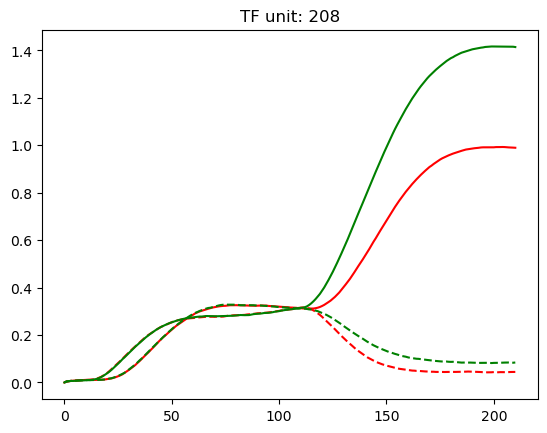

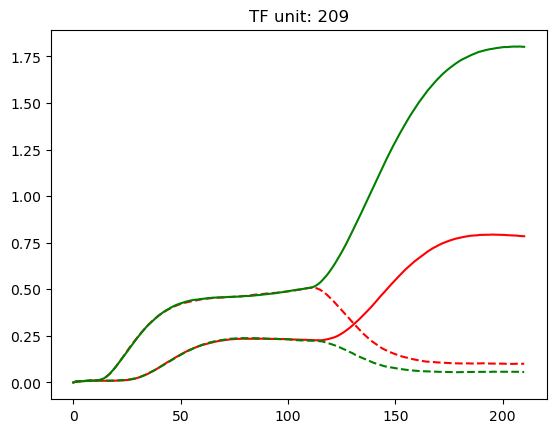

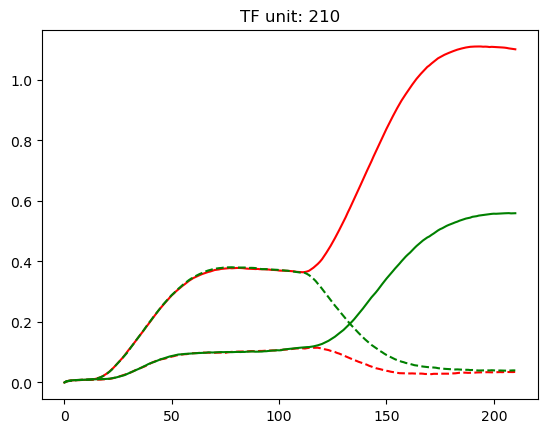

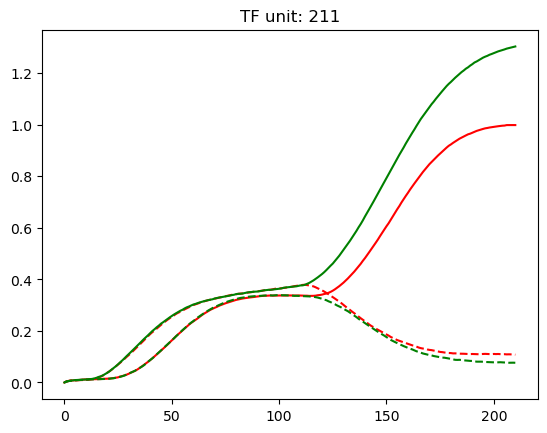

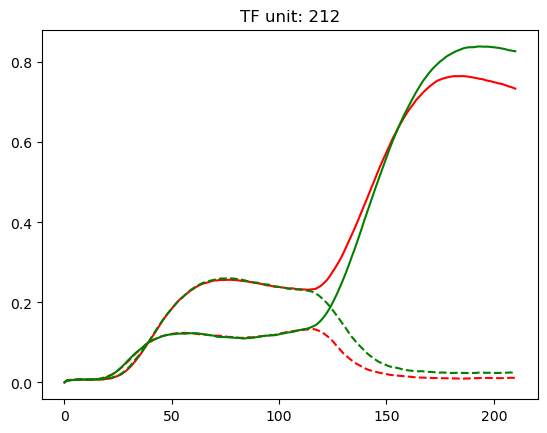

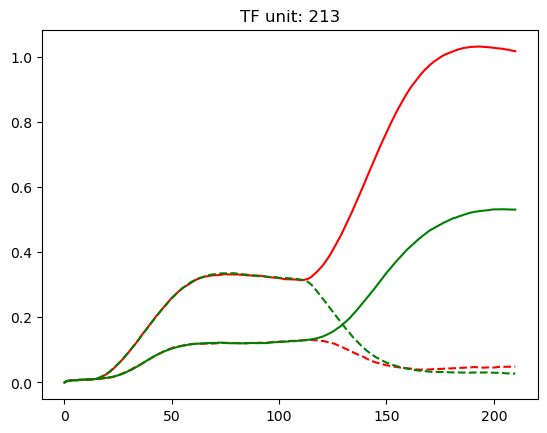

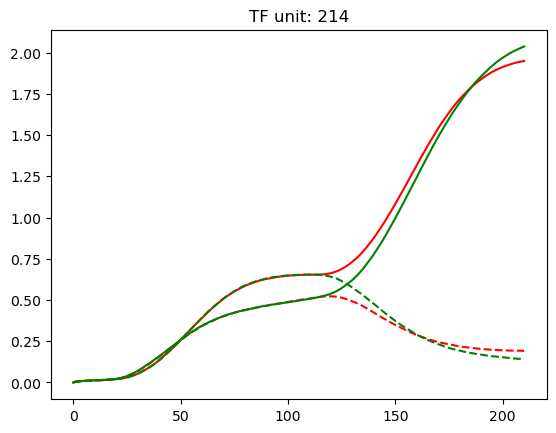

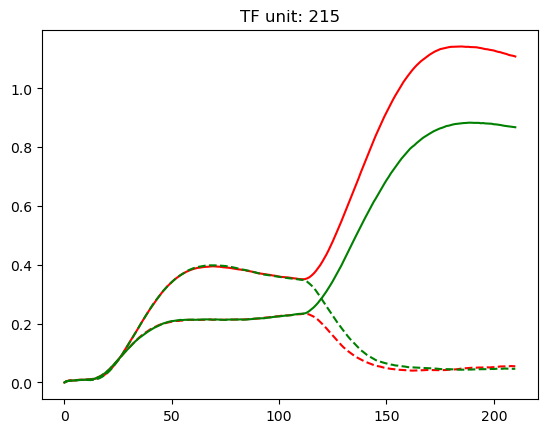

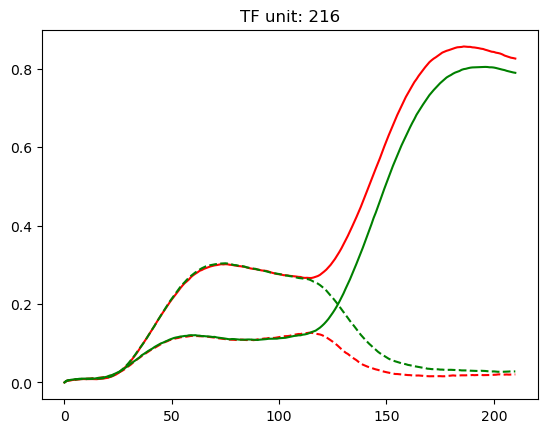

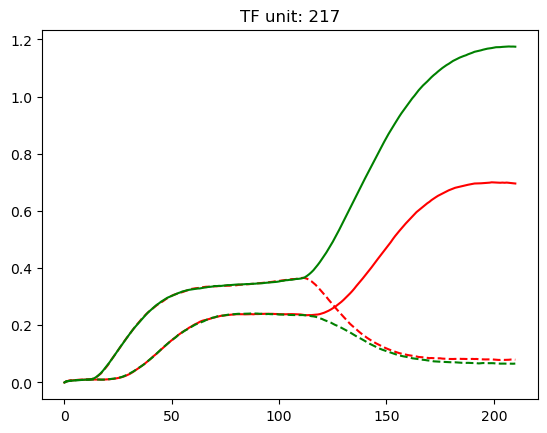

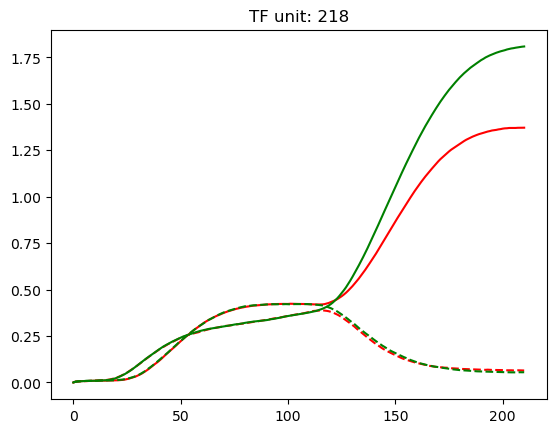

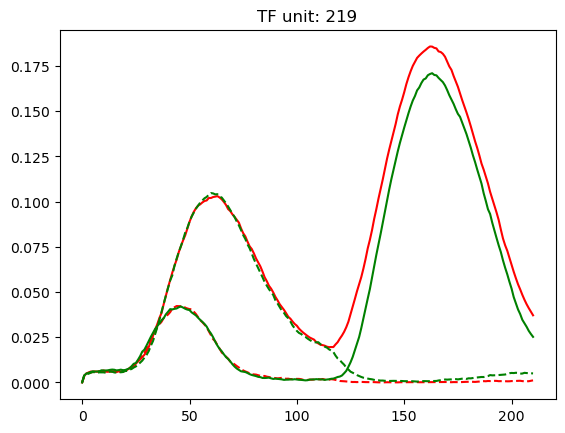

In [28]:
for n in range(40,50):
    plt.figure()
    plt.plot(np.mean(tfRL,axis = 0)[:,n], 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n], 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n], 'g--')
    plt.title("TF unit: " + str(n))
    

# plot the connectivity matrix


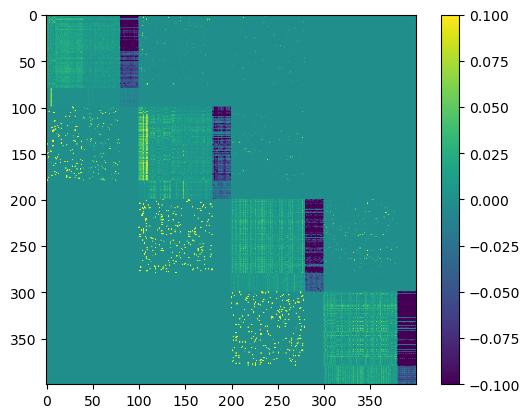

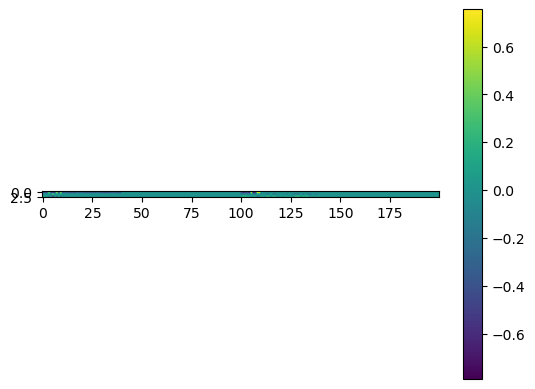

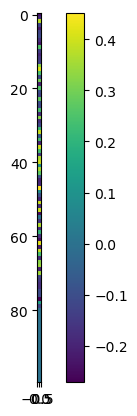

In [29]:
wrec = net.w_rec_eff.cpu()
wi = net.w_in_eff.cpu()
wo = net.w_out_eff.cpu()

a = wrec.detach().numpy()
plt.imshow(np.transpose(a))
plt.colorbar()
plt.set_cmap('viridis')
plt.clim(-0.1, 0.1)
plt.show()

b = wi.detach().numpy()
plt.imshow(b[:,:200])
plt.colorbar()
plt.set_cmap('viridis')
plt.show()

c = wo.detach().numpy()
plt.imshow(c[300:])
plt.colorbar()
plt.set_cmap('viridis')
plt.show()


model:  1 :


'../fr/4AreasArea2All3to1_{i}.mat'

In [21]:
trajLow = np.zeros((4, tfRL.shape[1], tfRL.shape[2]))
trajLow[0,:,:] = np.mean(tfRL,axis = 0)
trajLow[1,:,:] =np.mean(tfRR,axis = 0)
trajLow[2,:,:] =np.mean(tfGL,axis = 0)
trajLow[3,:,:] =np.mean(tfGR,axis = 0)

In [25]:
area = np.arange(0,400)

dim = trajLow.shape
firingRatesAverage = np.zeros((400,2,2,dim[1]))

firingRatesAverage[:,0,0,:] = (trajLow[0,:,area])
firingRatesAverage[:,0,1,:] = (trajLow[1,:,area])
firingRatesAverage[:,1,0,:] = (trajLow[2,:,area])
firingRatesAverage[:,1,1,:] = (trajLow[3,:,area])


In [26]:
from scipy.io import savemat
mdic = {"firingRatesAverage": firingRatesAverage}
savemat("../fr/4AreasArea12All3to1.mat", mdic)
